##### Copyright 2020 Atsushi Suzuki.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License. 

# This notebook is a modified version of https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb

# The original license is as follows:

# The MIT License (MIT)

# Copyright (c) 2016 Jacob VanderPlas

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Overfitting and regularization
- COMP 1801 IT lab: 27 Nov 2020
$\newcommand{\Vec}[1]{\boldsymbol{#1}}$
$\newcommand{\Mat}[1]{\boldsymbol{#1}}$
## Aim
- Learn the algorithm of k-means
- Experience applications of clustering
## Note: to execute a cell, press SHIFT + ENTER

## Import libraries
- matplotlib: for plotting
- NumPy: for vectors, matrices


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # for plotting
import seaborn as sns; sns.set()  # for plot styling
import numpy as np # linear algebra library

## Implementing k-means
### Notation
- $m$: # data points.
- $n$: # data dimensionality.
- $k$: # clusters.
- $\Vec{x}^{(i)} \in \mathbb{R}^{n}$: the $i$-th data point.
- $\Vec{\mu}^{[\ell]} \in \mathbb{R}^{n}$: the centroid of the $\ell$-th cluster.
- $c^{(i)} = 0, 1, \dots, k-1$: the cluster label (indicator) of the $i$-th data point.
- $\Vec{z}^{(i)} \in \mathbb{R}^{k}$: the one-hot vector indicating the cluster label of the $i$-th data point.

### Initialization
- Pick randomly $k$ points as initial centroids.

In [2]:
def get_initial_centroids(X, k):
  # input: 
  #   X: m x n, data matrix. X[i, :] is the i-th data point.
  #   k: integer, the number of clusters.
  # output: 
  #   Mu: k x n, centroids. Mu[l, :] is the centroid of the l-th cluster.
  Mu = X[np.random.choice(X.shape[0], k, replace=True)]
  return Mu

### Updating labels (indicators) (edit codes here)
- Update the cluster label (indicator) of each data point with the cluster that has the nearest centroid to the data point.
$$
\begin{eqnarray} 
c^{(i)} &\gets& \mathop{\mathrm{argmin}}_{\ell = 0,1,\dots,k-1} \left\| \Vec{x}^{(i)} - \Vec{\mu}^{[\ell]} \right\|^2,
&\textrm{for } i = 0, 1, \dots, m-1.
\\
z_{\ell}^{(i)} &\gets& \begin{cases} 1 & \textrm{if } \ell = c^{(i)}, \\ 0 & \textrm{otherwise,} \end{cases} 
&\textrm{for }
\begin{aligned} 
\ell &= 0, 1, \dots, k-1, \\ i &= 0, 1, \dots, m-1.
\end{aligned}
\end{eqnarray}
$$

#### Hint for implementation
- Step 1: Create 2d-array $\texttt{S}$ with size of $m \times k$ that satisfies the following:
$$
\texttt{S[i,l]} = \left\| \Vec{x}^{(i)} - \Vec{\mu}^{[\ell]} \right\|^2,
\textrm{for }
\begin{aligned} 
\ell &= 0, 1, \dots, k-1, \\ i &= 0, 1, \dots, m-1.
\end{aligned}
$$
- Step 2: Create label index 1d-array $\texttt{c}$ with length of $m$ such that $\texttt{c[i]}$ is the new cluster label of $i$-th data point. $\texttt{c[i]}$ is given by the index of the minimum element in the $\texttt{i}$-th row $\texttt{S[i, :]}$ of $\texttt{S}$. You can use [$\texttt{np.argmin}$ function](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html) and the $\texttt{axis}$ parameter.
- Step 3: Create 2d-array $\texttt{Z}$ such that $\texttt{Z[i, :]}$ is the one-hot vector that indicates the index $\texttt{c[i]}$. Please use the following website as a reference.
  - https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array


In [28]:
def update_labels(X, Mu):
  # input: 
  #   X: m x n, data matrix. X[i, :] is the i-th data point.
  #   Mu: k x n, centroids. Mu[l, :] is the centroid of the l-th cluster.
  # output: 
  #   Z: m x k, labels. Mu[m, :] is the one-hot vector that indicates the cluster label of i-th data point.
  m, n = X.shape
  k, n = Mu.shape
  Z = np.zeros([m, k], dtype=float)

  # ---- Edit code: implementation of uptating labels: start ----

  S = np.zeros([m, k], dtype=float)
  
  for i in range(m):
    for l in range(k):
      S[i, l] = np.sum((X[i, :] -  Mu[l, :]) ** 2) # can be made more efficent

  c = np.argmin(S, axis = 1)

  Z = np.eye(k)[c] # fancy indexing

  # ---- Edit code: implementation of uptating labels: end ----

  return Z


### Updating centroids (edit codes here)
- Update the centroid of each cluster with the arithmetric mean of the data points that belongs to the cluster.
$$ \Vec{\mu}^{[\ell]} \gets \frac{\sum_{i=0}^{m-1} z_{\ell}^{(i)} \Vec{x}^{(i)}}{\sum_{i=0}^{m-1} z_{\ell}^{(i)}}, \textrm{for } \ell = 0, 1, \dots, k-1.$$


In [34]:
def update_centroids(X, Z):
  # input: 
  #   X: m x n, data matrix. X[i, :] is the i-th data point.
  #   Z: m x k, labels. Z[i, :] is the one-hot vector that indicates the cluster label of i-th data point.
  # output: 
  #   Mu: k x n, centroids. Mu[l, :] is the centroid of the l-th cluster.
  m, n = X.shape
  m, k = Z.shape
  Mu = np.zeros([k, n])

  # ---- Edit code: implementation of uptating centroids: start ----
  for l in range(k):
    numerator = np.zeros([n], dtype=float)
    for i in range(m):
      numerator += Z[i,l] * X[i, :]

  Mu[l, :] = numerator / np.sum(Z[:, l])
  # ---- Edit code: implementation of uptating centroids: end ----

  return Mu


### Cost function
$$J = \sum_{i=0}^{m-1} \sum_{\ell=0}^{k-1} z_{\ell}^{(i)} \left\| \Vec{x}^{(i)} - \Vec{\mu}^{[\ell]} \right\|^2$$

In [30]:
def cost(X, Mu, Z):
  # input: 
  #   X: m x n, data matrix. X[i, :] is the i-th data point.
  #   Mu: k x n, centroids. Mu[l, :] is the centroid of the l-th cluster.
  #   Z: m x k, labels. Mu[m, :] is the one-hot vector that indicates the cluster label of i-th data point.
  # output: 
  #   J: real, cost function.
  J = 0.
  m, n = X.shape
  k, n = Mu.shape
  S = np.sum((X[:, np.newaxis, :] - Mu[np.newaxis, :, :]) ** 2, axis=-1)
  J = np.sum(Z * S)
  return J 

## Implement k-means class

In [31]:
class MYKMeans(object):
  def __init__(self, n_clusters):
    self.n_clusters = n_clusters

  def fit(self, X, max_iter=10):
    k = self.n_clusters
    Mu = get_initial_centroids(X, k)
    cost_history = {
      'label': np.zeros([max_iter], dtype=float),
      'centroid': np.zeros([max_iter], dtype=float),
    }

    for i in range(max_iter):
      Z = update_labels(X, Mu)
      cost_history['label'][i] = cost(X, Mu, Z)
      Mu = update_centroids(X, Z)
      cost_history['centroid'][i] = cost(X, Mu, Z)
    self.cost_history = cost_history
    self.cluster_centers_ = Mu

  def predict(self, X):
    Mu = self.cluster_centers_
    Z = update_labels(X, Mu)
    c = np.argmax(Z, axis=-1)
    return c


## Creating a toy dataset

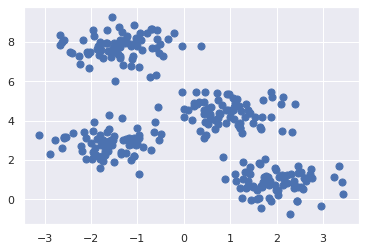

In [32]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

## Fit to the data

In [35]:
np.random.seed(0)
kmeans = MYKMeans(n_clusters=4)
max_iter = 10
kmeans.fit(X, max_iter=max_iter)
labels = kmeans.predict(X)

## Plot the loss function

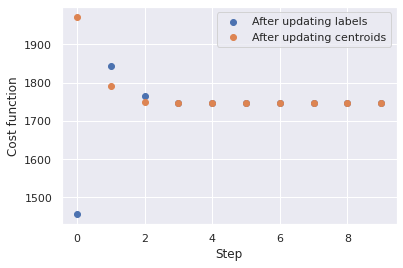

In [36]:
plt.scatter(np.arange(max_iter), kmeans.cost_history['label'], label='After updating labels')
plt.scatter(np.arange(max_iter), kmeans.cost_history['centroid'], label='After updating centroids')
plt.xlabel('Step')
plt.ylabel('Cost function')
plt.legend()

## Plot the clustering results

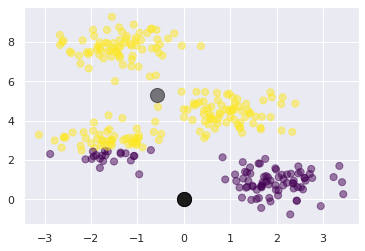

In [37]:
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis', alpha=0.5)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## Let's use scikit learn implementation!

In [38]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
labels = kmeans.predict(X)

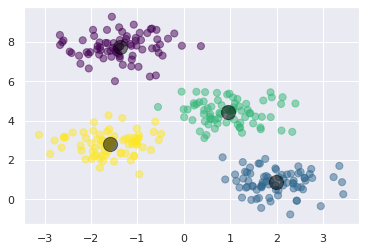

In [39]:
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis', alpha=0.5)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## Too many clusters

In [40]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
labels = kmeans.predict(X)

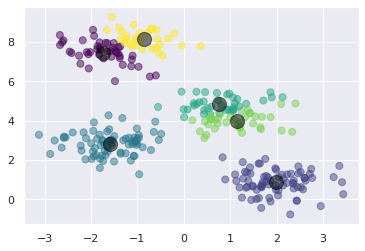

In [41]:
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis', alpha=0.5)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## Moon shape dataset

In [42]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

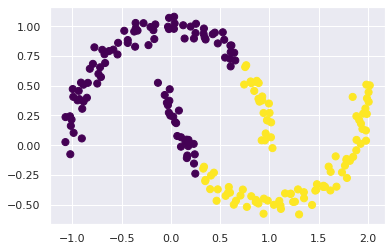

In [43]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

## Spectral Clustering

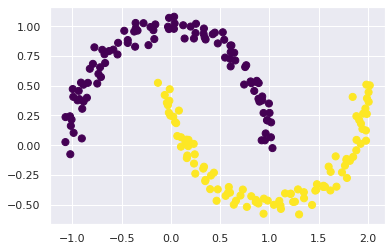

In [44]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

## Application I: digit clustering

In [45]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

### Displaying the digit data

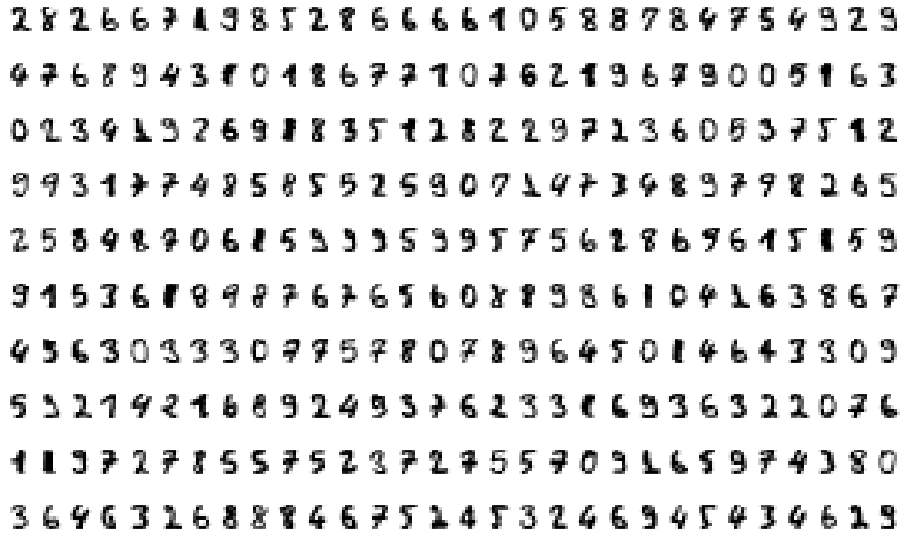

In [46]:
np.random.seed(0)
n_rows = 10
n_cols = 30
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 10))
random_digits = digits.data[np.random.choice(digits.data.shape[0], size = n_rows * n_cols, replace=False)]
for axi, center in zip(ax.flat, random_digits.reshape(-1, 8, 8)):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)
fig.show()

### Applying the k-means algorithm

In [47]:
from sklearn.cluster import KMeans
np.random.seed(0)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

### Displaying the clustering results

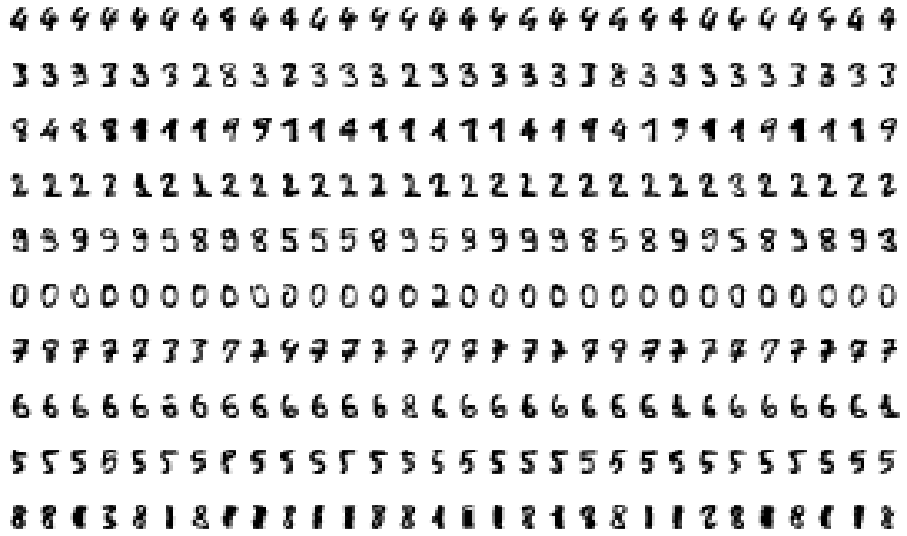

In [48]:
np.random.seed(0)
n_rows = 10
n_cols = 30
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, 10))
digit_clusters = [digits.data[clusters==i_cluster] for i_cluster in range(n_clusters)] 
for ax_row, digit_cluster in zip(ax, digit_clusters):
  for axi, digit_data in zip(ax_row, digit_cluster[np.random.choice(digit_cluster.shape[0], n_cols, replace=False)]):
    axi.set(xticks=[], yticks=[])
    axi.imshow(digit_data.reshape(8, 8), interpolation='nearest', cmap=plt.cm.binary)
fig.show()

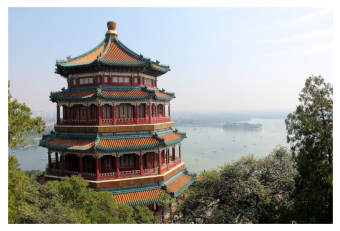

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);
fig.show()

### Plotting pixels in the RGB colour space

In [50]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20)
    return fig

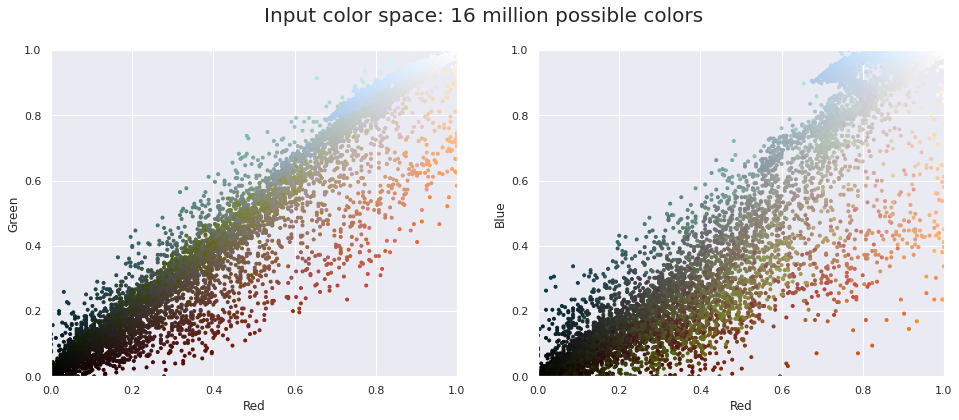

In [51]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
fig = plot_pixels(data, title='Input color space: 16 million possible colors')
fig.show()


### Plotting pixels with compressed colours

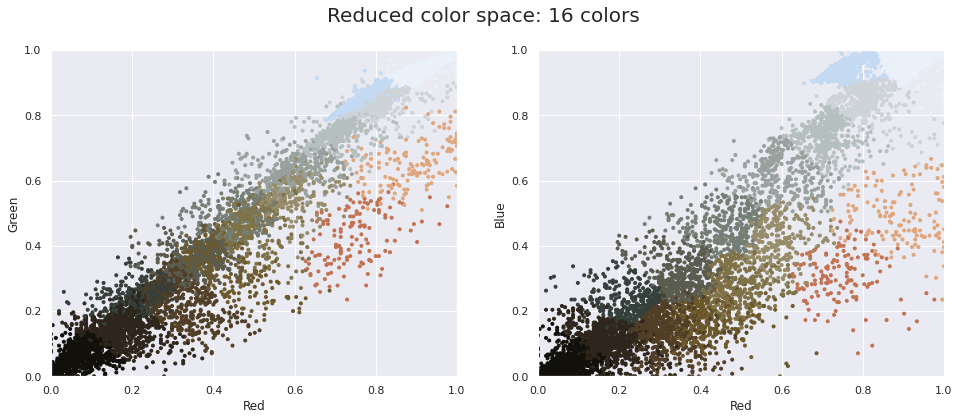

In [52]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

fig = plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")
fig.show()

### Displaying the recoloured image with compressed colours.

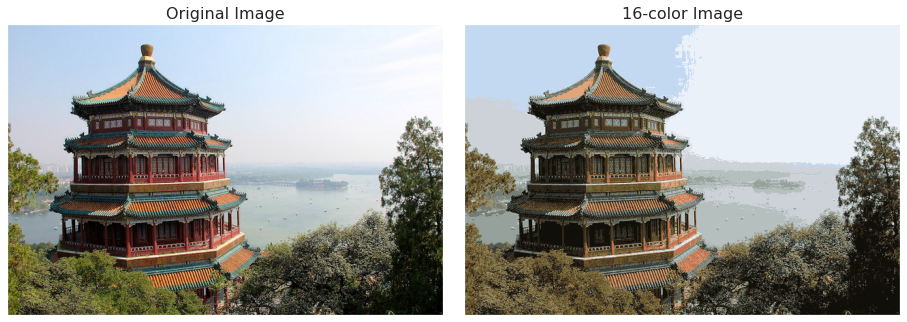

In [53]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);
fig.show()